# Visualizing Barren Plateaus

[References](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [1]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [2]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [3]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 2
PCA Explained variance: [443782.6051466    7310.10006165]
Classes:[0 1]; Encoded as: [-1  1]


In [4]:
LOG_PATH = '../VQA-Notes-v2/Logs-Cancer-v4'
# LOG_PATH = 'Logs-Cancer-v4'

In [5]:
surface0 = pd.read_csv(f'{LOG_PATH}/m0/LossFunctionSurface.csv', index_col=0)
path0 = pd.read_csv(f'{LOG_PATH}/m0/m0-0-Weights.csv', index_col=0)
path0[path0.shape[1]] = pd.read_csv(f'{LOG_PATH}/m0/m0-0-LossFunction.csv', index_col=0)
# Drop column names so we can concat()...
surface0 = surface0.transpose().reset_index(drop=True).transpose()
path0 = path0.transpose().reset_index(drop=True).transpose()

surface1 = pd.read_csv(f'{LOG_PATH}/m1/LossFunctionSurface.csv', index_col=0)
path1 = pd.read_csv(f'{LOG_PATH}/m1/m1-1-Weights.csv', index_col=0)
path1[path1.shape[1]] = pd.read_csv(f'{LOG_PATH}/m1/m1-1-LossFunction.csv', index_col=0)
surface1 = surface1.transpose().reset_index(drop=True).transpose()
path1 = path1.transpose().reset_index(drop=True).transpose()

surface2 = pd.read_csv(f'{LOG_PATH}/m2/LossFunctionSurface.csv', index_col=0)
path2 = pd.read_csv(f'{LOG_PATH}/m2/m2-0-Weights.csv', index_col=0)
path2[path2.shape[1]] = pd.read_csv(f'{LOG_PATH}/m2/m2-0-LossFunction.csv', index_col=0)
surface2 = surface2.transpose().reset_index(drop=True).transpose()
path2 = path2.transpose().reset_index(drop=True).transpose()

surface3 = pd.read_csv(f'{LOG_PATH}/m3/LossFunctionSurface.csv', index_col=0)
path3 = pd.read_csv(f'{LOG_PATH}/m3/m3-3-Weights.csv', index_col=0)
path3[path3.shape[1]] = pd.read_csv(f'{LOG_PATH}/m3/m3-3-LossFunction.csv', index_col=0)
surface3 = surface3.transpose().reset_index(drop=True).transpose()
path3 = path3.transpose().reset_index(drop=True).transpose()

In [6]:
from sklearn.decomposition import PCA

def plotSurface(surface:pd.DataFrame, path=None, title = '', save:str = None, dpi = 80, pcs=(0, 1), pc_max=2, plot_path=True):
    '''
    use %matplotlib widget for interative plot!
    '''
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]
    pca = PCA(n_components=pc_max)
    pca.fit(parameters)
    principalSurfaceData = pca.transform(parameters)
    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    
    principalSurfaceDataDF = pd.DataFrame()
    principalSurfaceDataDF['x'] = principalSurfaceData[:, pcs[0]]
    principalSurfaceDataDF['y'] = principalSurfaceData[:, pcs[1]]
    principalSurfaceDataDF['z'] = zValue
    
    from mpl_toolkits.mplot3d import Axes3D
    surfaceXs = principalSurfaceDataDF['x']
    surfaceYs = principalSurfaceDataDF['y']
    surfaceZs = principalSurfaceDataDF['z']
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel(f'Params PC{pcs[0]+1}')
    ax.set_ylabel(f'Params PC{pcs[1]+1}')
    ax.set_zlabel('Means Absolute Error')
    ax.set_title(title)
    
    plot = ax.plot_trisurf(surfaceXs,
                       surfaceYs,
                       surfaceZs,
                       cmap=plt.get_cmap('rainbow_r'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)
    
    plt.colorbar(plot, shrink=0.5, aspect=5)

    if path is not None and plot_path:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]
        principalPathData = pca.transform(pathParameters)
        principalPathDataDF = pd.DataFrame()
        principalPathDataDF['x'] = principalPathData[:, pcs[0]]
        principalPathDataDF['y'] = principalPathData[:, pcs[1]]
        principalPathDataDF['z'] = pathZvalue
        
        ax.plot3D(principalPathDataDF['x'],
                principalPathDataDF['y'],
                principalPathDataDF['z'],
                color='red',
                linewidth=3,
                antialiased=False,
                alpha=1)

    plt.show()

    if save:
        plt.savefig(save)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 5.094522
[t-SNE] KL divergence after 150 iterations with early exaggeration: 63.918295
[t-SNE] KL divergence after 300 iterations: 2.496174
t-SNE done! Time elapsed: 45.460087060928345 seconds


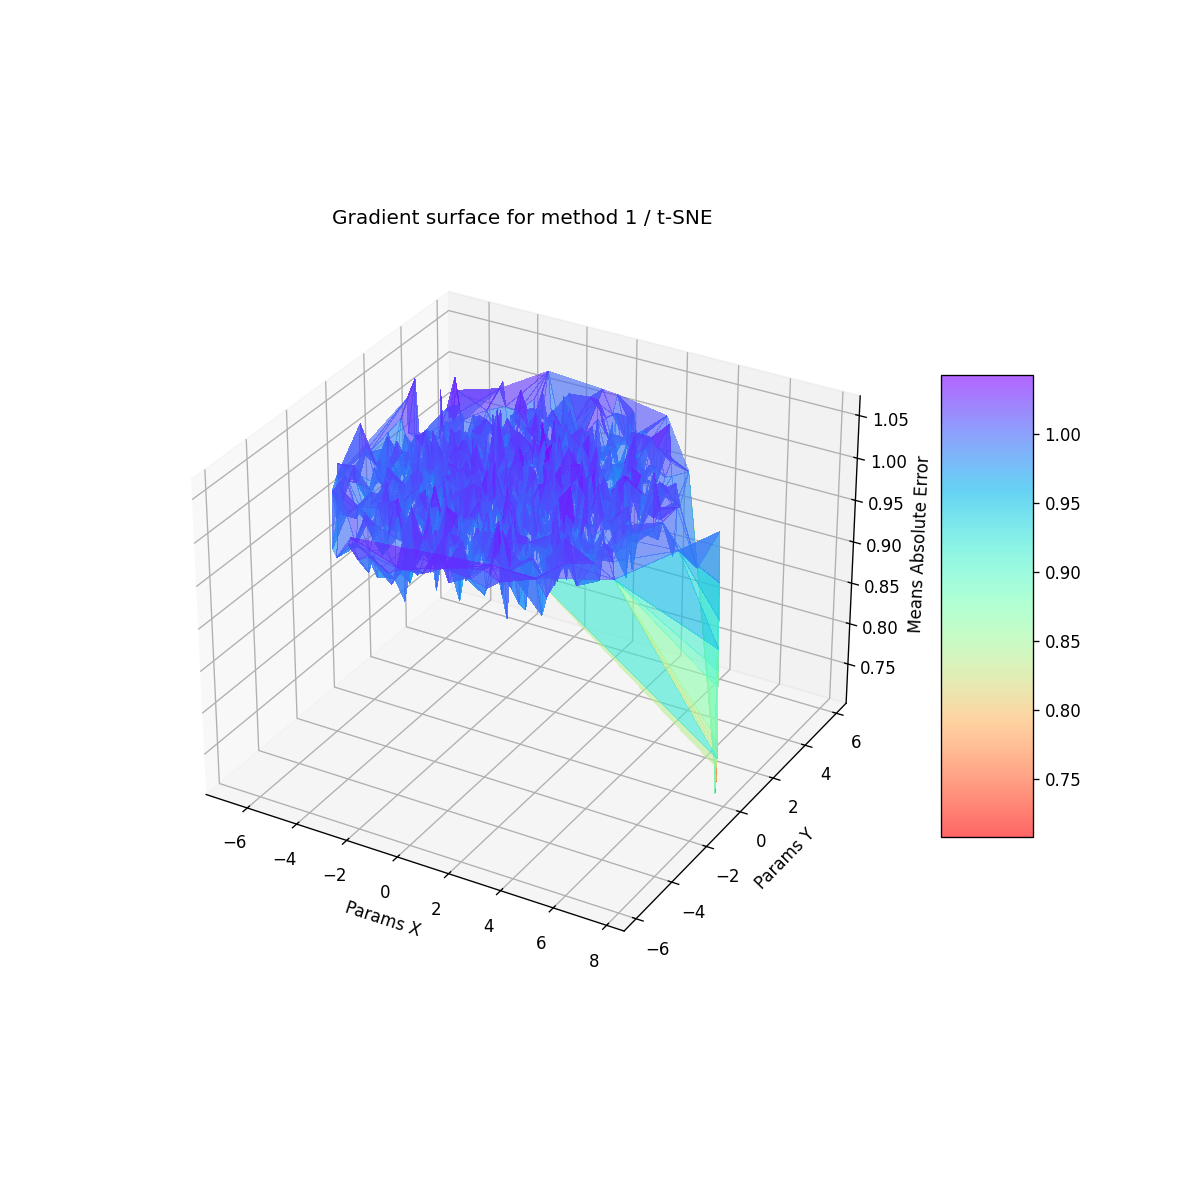

In [15]:
from sklearn.manifold import TSNE
import time
%matplotlib widget

def plotTSNESurface(surface:pd.DataFrame, path=None, title = 'Gradient surface', 
                    save:str = None, dpi = 120, pcs=(0, 1), pc_max=3, plot_path=False,
                    method='barnes_hut'):

    # data = pd.concat([surface, path], ignore_index=True)
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]
    
    time_start = time.time()
    tsne = TSNE(n_components=pc_max, verbose=1, perplexity=100, n_iter=300, method=method)
    tsne_results = tsne.fit_transform(parameters)
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel(f'Params X')
    ax.set_ylabel(f'Params Y')
    ax.set_zlabel('Means Absolute Error')
    ax.set_title(title)
    
    plot = ax.plot_trisurf(tsne_results[:,pcs[0]],
                           tsne_results[:,pcs[1]],
                           zValue,
                           cmap=plt.get_cmap('rainbow_r'),
                           linewidth=1,
                           antialiased=False,
                           alpha=0.6)

    # In TSNE you cannot add more data points
    if path is not None and plot_path:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]

        tsne_path_results = tsne.fit_transform(pathParameters)

        ax.plot3D(tsne_path_results[:,pcs[0]],
                  tsne_path_results[:,pcs[1]],
                  pathZvalue,
                  color='red',
                  linewidth=3,
                  antialiased=False,
                  alpha=1)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    plt.colorbar(plot, shrink=0.5, aspect=5)
    plt.show()

    if save:
        plt.savefig(save)

plotTSNESurface(surface0, path=path0, title='Gradient surface for method 1 / t-SNE', dpi=120, pcs=(0,1), pc_max=3, save='m1_tsne.png', method='exact')

Isomap done! Time elapsed: 2.7656471729278564 seconds


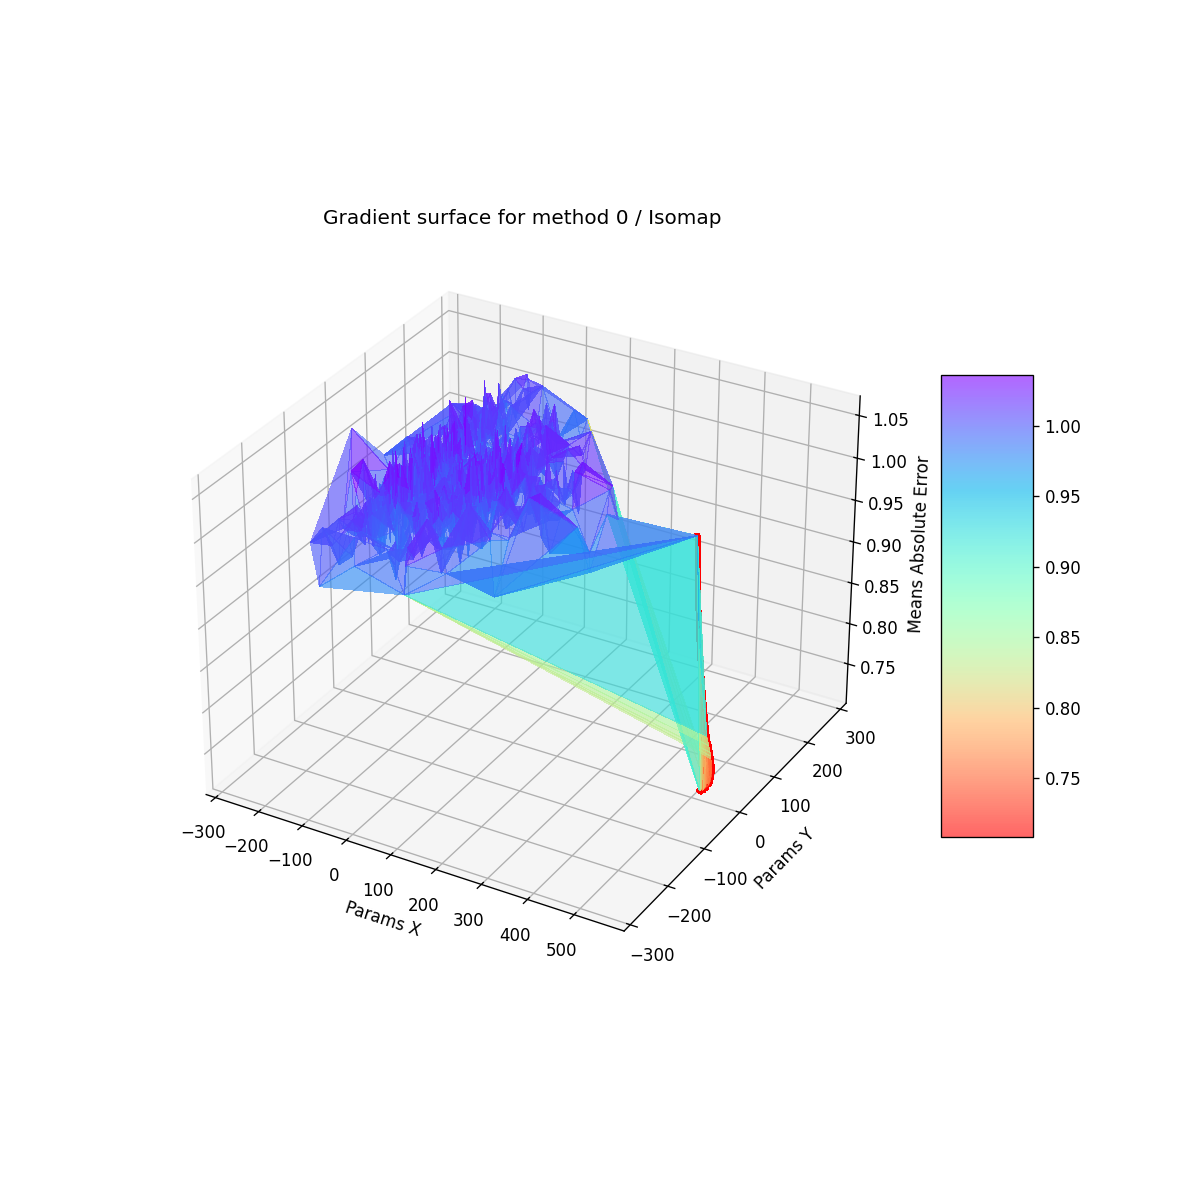

In [8]:
from sklearn.manifold import Isomap
import time
%matplotlib widget

def plotIsomapSurface(surface:pd.DataFrame, path=None, title = 'Gradient surface', 
                    save:str = None, dpi = 120, pcs=(0, 1), pc_max=3, plot_path=True,
                    metric='minkowski'):

    # data = pd.concat([surface, path], ignore_index=True)
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]
    
    time_start = time.time()
    tsne = Isomap(n_components=pc_max, n_neighbors=10, metric=metric).fit(parameters)
    tsne_results = tsne.transform(parameters)
    
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel(f'Params X')
    ax.set_ylabel(f'Params Y')
    ax.set_zlabel('Means Absolute Error')
    ax.set_title(title)
    
    plot = ax.plot_trisurf(tsne_results[:,pcs[0]],
                           tsne_results[:,pcs[1]],
                           zValue,
                           cmap=plt.get_cmap('rainbow_r'),
                           linewidth=1,
                           antialiased=False,
                           alpha=0.6)

    if path is not None and plot_path:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]

        tsne_path_results = tsne.transform(pathParameters)

        ax.plot3D(tsne_path_results[:,pcs[0]],
                  tsne_path_results[:,pcs[1]],
                  pathZvalue,
                  color='red',
                  linewidth=3,
                  antialiased=False,
                  alpha=1)

    print('Isomap done! Time elapsed: {} seconds'.format(time.time()-time_start))

    plt.colorbar(plot, shrink=0.5, aspect=5)
    plt.show()

    if save:
        plt.savefig(save)

# Possible values for 'metric', default is 'minkowski'
metrics = {'haversine', 'precomputed', 'russellrao', 'euclidean', 'seuclidean', 'correlation', 'sokalsneath', 'l2', 'dice', 'wminkowski', 
           'chebyshev', 'minkowski', 'sqeuclidean', 'canberra', 'jaccard', 'yule', 'cityblock', 'nan_euclidean', 'sokalmichener', 
           'rogerstanimoto', 'braycurtis', 'hamming', 'l1', 'mahalanobis', 'cosine', 'manhattan'}
plotIsomapSurface(surface0, path=path0, title='Gradient surface for method 0 / Isomap', metric='l1', # good: minkowski, cityblock, manhattan, chebyshev, euclidean, nan_euclidean, l1, l2
                  dpi=120, pcs=(0,1), pc_max=5, save='m0_isomap.png')

/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-orAwPlel/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP done! Time elapsed: 13.26856517791748 seconds


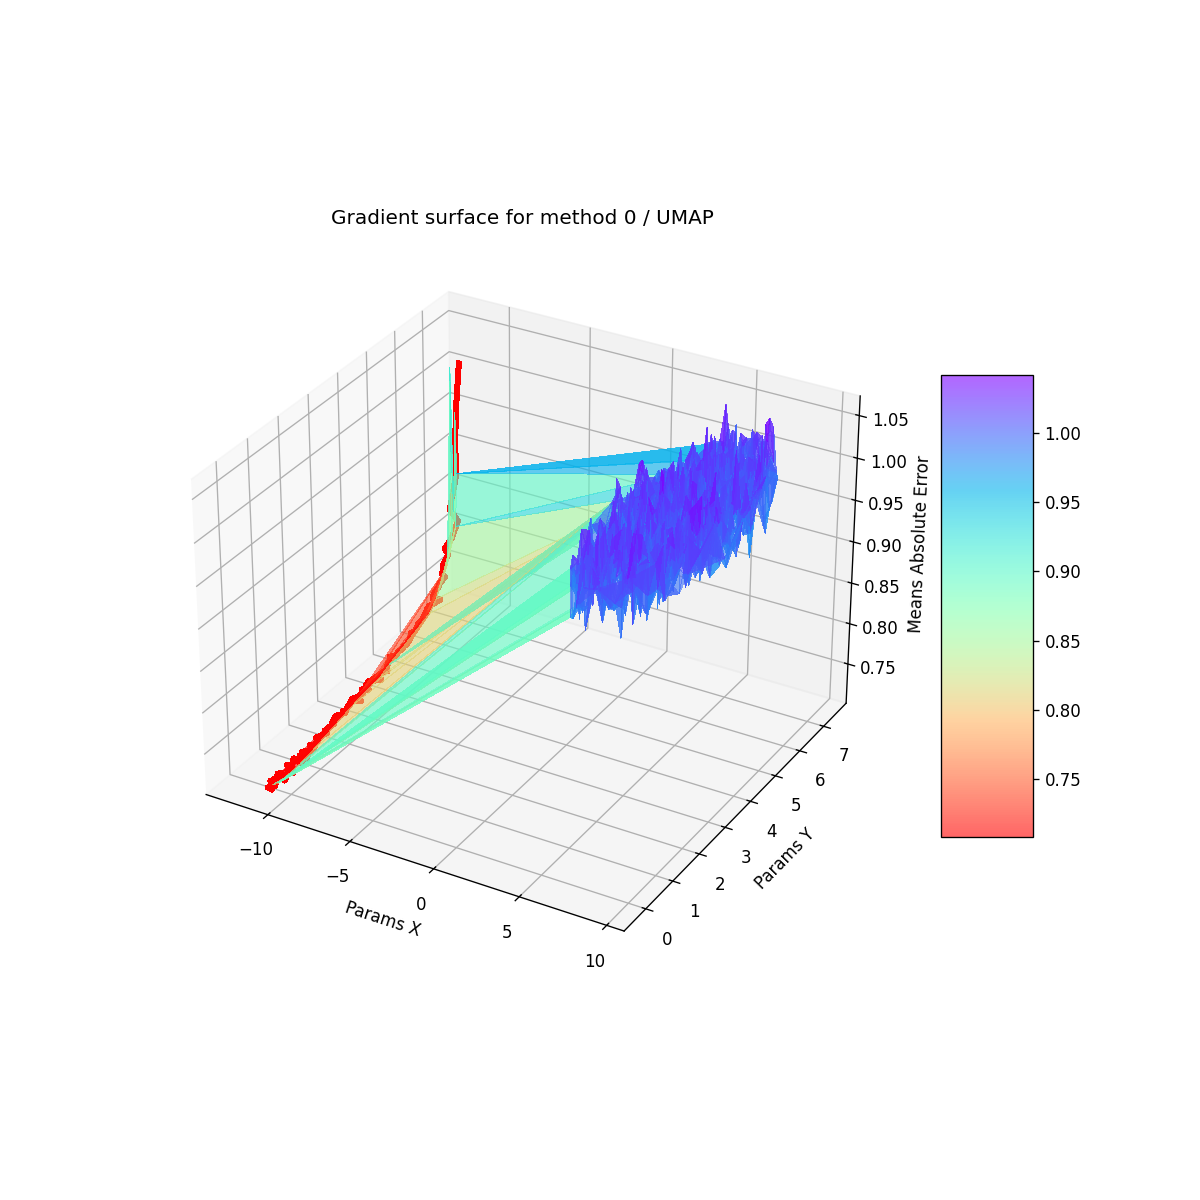

In [9]:
from umap import UMAP
%matplotlib widget

def plotUMAPSurface(surface:pd.DataFrame, path=None, title = 'Gradient surface', 
                    save:str = None, dpi = 80, pcs=(0, 1), pc_max=2, plot_path=False,
                    metric='cosine'):

    # data = pd.concat([surface, path], ignore_index=True)
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]
    
    time_start = time.time()
    umap_model = UMAP(n_components=pc_max, init='spectral', random_state=42, 
                      n_neighbors=40, min_dist=0.5, spread=3.0, repulsion_strength=0.5, learning_rate=0.5,
                      metric=metric, local_connectivity=0.05
                     ).fit(parameters)
    umap_results = umap_model.transform(parameters)
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel(f'Params X')
    ax.set_ylabel(f'Params Y')
    ax.set_zlabel('Means Absolute Error')
    ax.set_title(title)
    
    plot = ax.plot_trisurf(umap_results[:,pcs[0]],
                           umap_results[:,pcs[1]],
                           zValue,
                           cmap=plt.get_cmap('rainbow_r'),
                           linewidth=1,
                           antialiased=False,
                           alpha=0.6)

    # In TSNE you cannot add more data points
    if path is not None and plot_path:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]

        umap_path_results = umap_model.transform(pathParameters)

        ax.plot3D(umap_path_results[:,pcs[0]],
                  umap_path_results[:,pcs[1]],
                  pathZvalue,
                  color='red',
                  linewidth=3,
                  antialiased=False,
                  alpha=1)

    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    plt.colorbar(plot, shrink=0.5, aspect=5)
    plt.show()

    if save:
        plt.savefig(save)

plotUMAPSurface(surface0, path=path0, title='Gradient surface for method 0 / UMAP', dpi=120, plot_path=True, save='m0_umap.png', pcs=(0, 1), pc_max=3, metric='cosine')

Explained Variance Ratio: [0.06107669 0.01334149]


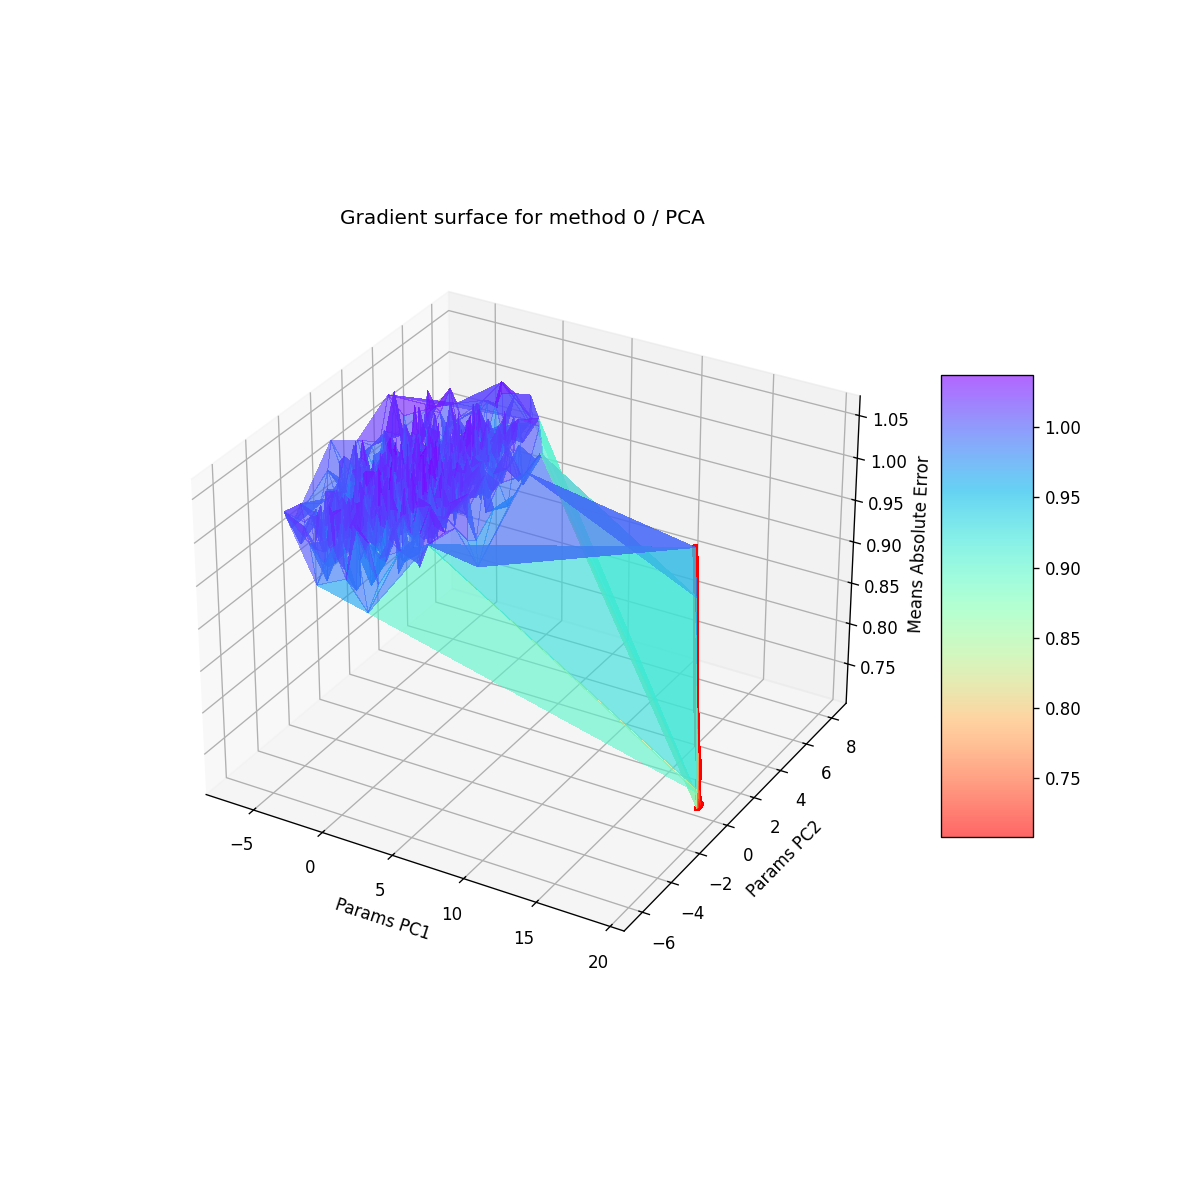

In [10]:
%matplotlib widget
plotSurface(surface0, path=path0, title='Gradient surface for method 0 / PCA', dpi=120, save='m0.png')

Explained Variance Ratio: [0.07685873 0.07126131]


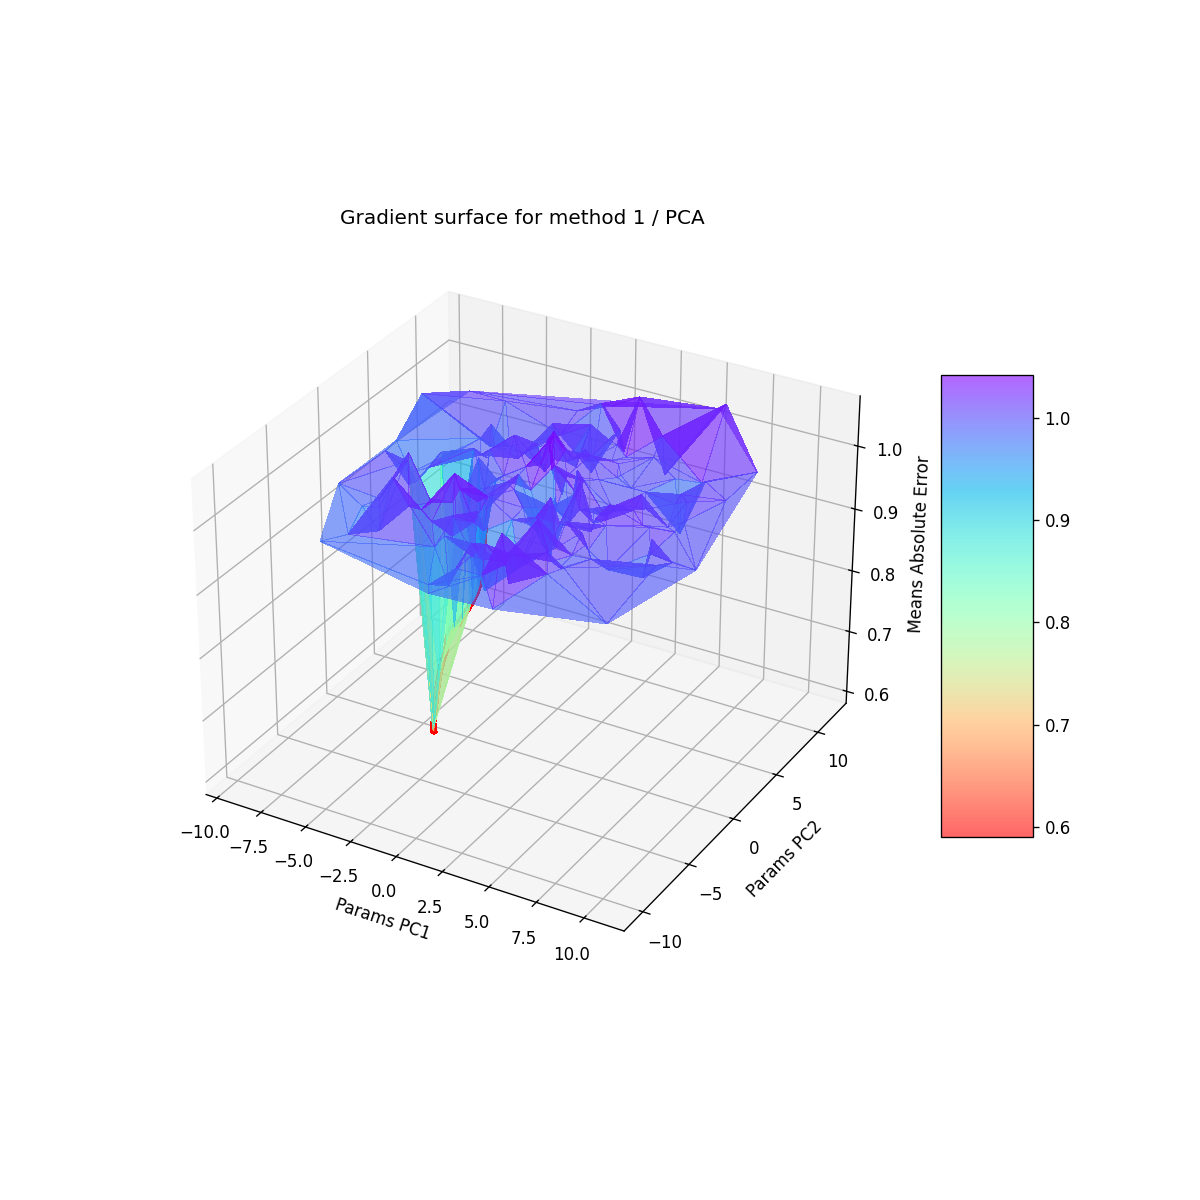

In [11]:
%matplotlib widget
plotSurface(surface1, path=path1, title='Gradient surface for method 1 / PCA', dpi=120, save='m1.png')

Explained Variance Ratio: [0.02838927 0.02629587]


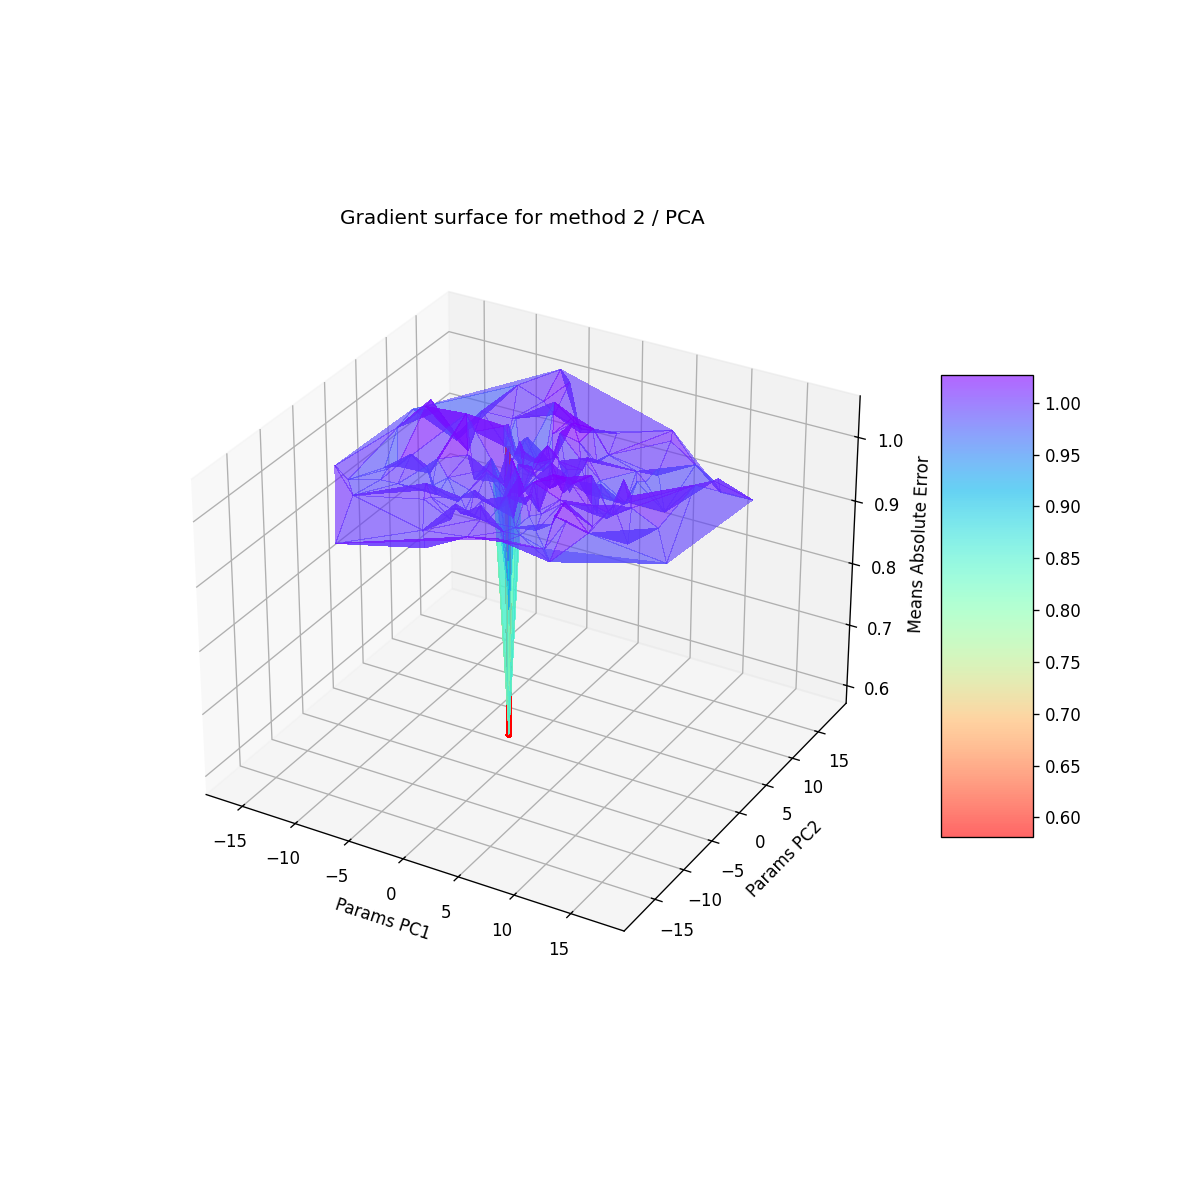

In [12]:
%matplotlib widget
plotSurface(surface2, path=path2, title='Gradient surface for method 2 / PCA', dpi=120, save='m2.png')

Explained Variance Ratio: [0.23550141 0.01935466 0.0185331  0.01830614 0.01758889 0.01728238
 0.01661403 0.01605047 0.01589172 0.0155811 ]


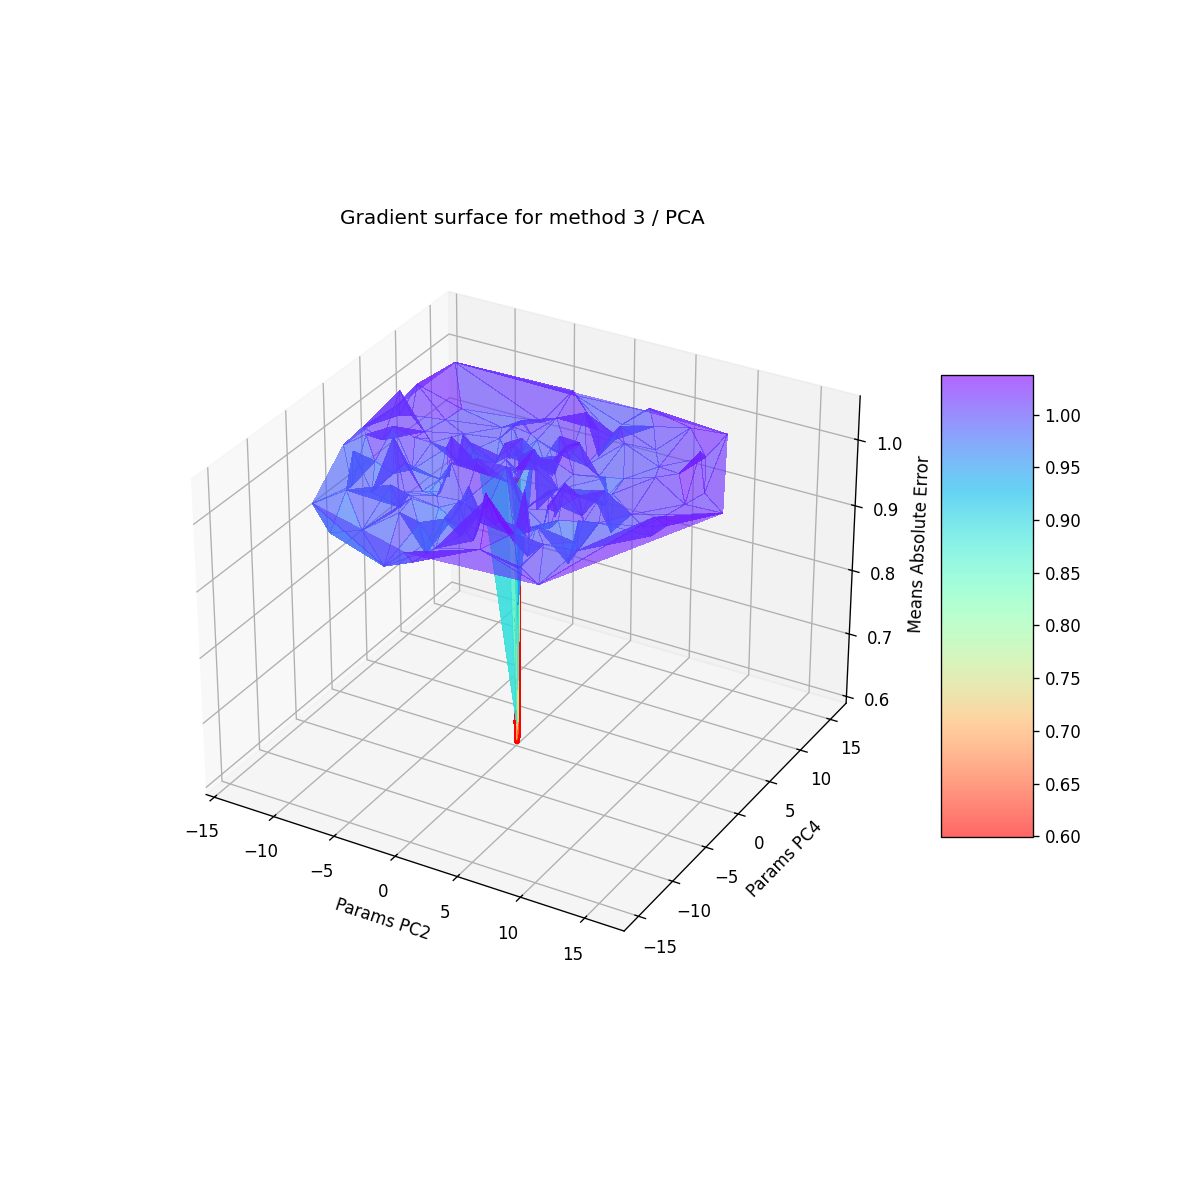

In [13]:
%matplotlib widget
plotSurface(surface3, path=path3, title='Gradient surface for method 3 / PCA', dpi=120, save='m3.png', pc_max=10, pcs=(1, 3))

In [14]:
!pip list | grep -e qiskit -e torch

qiskit                    1.0.2
qiskit-aer                0.14.1
qiskit-algorithms         0.3.0
qiskit-ibm-runtime        0.23.0
qiskit-machine-learning   0.7.2
qiskit_qulacs             0.0.0
torch                     1.11.0
torchsummary              1.5.1
torchvision               0.14.1
